This notebook find DDSM and corresponging CBIS-DDSM images.

The idea is:
1. Use size, laterality and view to find the possible candidates.
2. For each candidate, calculate the similarity between the images.

It is important to consider, that intensity normalization is different. For these reason CBIS ddsm are renormalized using the same method as DDSM (dezso method). This improves a lot the quality of the similarity.



In [14]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
from tqdm import tqdm

In [2]:
data_folder = pathlib.Path('/home/alalbiol/Data/mamo')
data_folder = pathlib.Path('/media/HD/mamo')
cbis_ddsm_path = data_folder / 'CBIS-DDSM'
#ddsm_path = data_folder / 'DDSM_png' # imagenes con 8 bits tipo dezso
ddsm_path = data_folder / 'DDSM_png_noclipping' # imagenes con 16 bits

In [3]:
all_cbis_images = list(cbis_ddsm_path.glob('**/*.png'))
print(f'CBIS-DDSM images: {len(all_cbis_images)} pero muchas son mascaras y crops')
all_ddsm_images = list(ddsm_path.glob('**/*.png'))
print(f'DDSM images: {len(all_ddsm_images)} pero muchas son casos normales')

CBIS-DDSM images: 10239 pero muchas son mascaras y crops
DDSM images: 10420 pero muchas son casos normales


In [4]:
calc_case_test = pd.read_csv( '../resources/cbis_ddsm/calc_case_description_test_set.csv')
calc_case_train = pd.read_csv( '../resources/cbis_ddsm/calc_case_description_train_set.csv')
mass_case_test = pd.read_csv( '../resources/cbis_ddsm/mass_case_description_test_set.csv')
mass_case_train = pd.read_csv( '../resources/cbis_ddsm/mass_case_description_train_set.csv')
all_case_train = pd.concat([calc_case_train, mass_case_train])
all_case_test = pd.concat([calc_case_test, mass_case_test])
all_case = pd.concat([all_case_train, all_case_test])

print(f'calc_case_test: {len(calc_case_test)}')
print(f'calc_case_train: {len(calc_case_train)}')
print(f'mass_case_test: {len(mass_case_test)}')
print(f'mass_case_train: {len(mass_case_train)}')
print(f'all_case_train: {len(all_case_train)}')
print(f'all_case_test: {len(all_case_test)}')
print(f'all_case: {len(all_case)} pero algunas son repetidas porque CBIS repite imagenes por lesiones')


calc_case_test: 326
calc_case_train: 1546
mass_case_test: 378
mass_case_train: 1318
all_case_train: 2864
all_case_test: 704
all_case: 3568 pero algunas son repetidas porque CBIS repite imagenes por lesiones


In [67]:
#create data frame with all ddsm images
ddsm_images = pd.DataFrame(all_ddsm_images, columns=['image_path'])
def get_image_size(image_path):
    image = Image.open(image_path)
    return image.size

def lat_orientation(image_path):
    name = image_path.stem
    return  name.split('.')[-1]

ddsm_images['image_size'] = ddsm_images['image_path'].apply(get_image_size)
ddsm_images['lat_orientation'] = ddsm_images['image_path'].apply(lat_orientation)

In [68]:
ddsm_images.lat_orientation.value_counts()
print("Logico porque de cada estudio tenemos dos mamas y dos vistas")

Logico porque de cada estudio tenemos dos mamas y dos vistas


Ahrora creamos un id basado en size_lat_orientation

In [69]:
def set_id(row):
    im_size = f"{row['image_size'][0]}_{row['image_size'][1]}"
    return f"{row['lat_orientation']}_{im_size}"

ddsm_images['id'] = ddsm_images.apply(set_id, axis=1)

In [70]:
print(len(ddsm_images.id.unique()))
print(len(ddsm_images)) 
# tenemos casi identificada cada imagen con esta firma basada en tamaño y orientación

9026
10420


In [9]:
def has_overlay(image_path):
    overlay_file = image_path.with_suffix('.OVERLAY')
    return overlay_file.exists()

print("Solo las imagenes con overlay pueden tener correspondencias con CBIS-DDSM")
ddsm_images['has_overlay'] = ddsm_images['image_path'].apply(has_overlay)
ddsm_images['has_overlay'].value_counts()
print("Nos quedamos solo con las que tienen overlay")

Solo las imagenes con overlay pueden tener correspondencias con CBIS-DDSM
Nos quedamos solo con las que tienen overlay


In [10]:
ddsm_images_candidates = ddsm_images[ddsm_images['has_overlay']]

# candidatos de encontrar en el directorio de cbis-ddsm
print("Numero de imagenes con overlay ", len(ddsm_images_candidates))
print("numero de imagenes en ddsm", len(ddsm_images))

# como hay menos ids, algunas imagenes puede corresponder a varios en cbis o alreves
print("numero de ids", len(ddsm_images_candidates.id.unique()))



Numero de imagenes con overlay  4029
numero de imagenes en ddsm 10420
numero de ids 3712


In [11]:
# repetimos el proceso para cbis-ddsm sacamos firma basada en tamaño y orientación
def image_size(filename):
    filename = filename.replace('dcm','png')
    filename = cbis_ddsm_path / filename
    parent_folder = filename.parent
    #filename = parent_folder / '000000.png'
    image = Image.open(filename)
    return image.size

all_case['image_size'] = all_case['image file path'].apply(image_size)


print("El numero total de imagenes CBIS", len(all_case['image_size']))
print("El numero de tamaños unicos", len(all_case['image_size'].unique()))


El numero total de imagenes CBIS 3568
El numero de tamaños unicos 2621


In [20]:
def set_id_cbis(row):
    im_size = f"{row['image_size'][0]}_{row['image_size'][1]}"
    return f"{row['left or right breast']}_{row['image view']}_{im_size}"

all_case['id'] = all_case.apply(set_id_cbis, axis=1)

print("Numero de imagenes CBIS", len(all_case))
print("Numero de ids unicos", len(all_case['id'].unique()))


Numero de imagenes CBIS 3568
Numero de ids unicos 2875


In [12]:
"Comparamos ids de CBIS con DDSM"
print("DDSM")
print(ddsm_images['id'].head())
print("CBIS")
print(all_case['id'].head())

DDSM
0      LEFT_CC_3241_5341
1     RIGHT_CC_3526_5326
2    RIGHT_MLO_3751_5386
3     LEFT_MLO_3196_5326
4      LEFT_CC_1831_3886
Name: id, dtype: object
CBIS


KeyError: 'id'

In [15]:
def find_ddsm_image(row):
    cbis_id = row['id'] 
    # solo buscamos candidatos con misma firma tamaño y orientación y lateralidad
    candidates = ddsm_images_candidates[ddsm_images_candidates['id'] == cbis_id].image_path
    
    if len(candidates) == 0:
        print(f'warning: No candidate for {cbis_id}')
        return None
    
    return candidates.values
    

# Para cada imagen CBIS buscamos candidatos en DDSM y lo deja en una columna 
all_case['ddsm_image'] = all_case.apply(find_ddsm_image, axis=1)

Todos los casos de cbis tienen una imagen en ddsm porque no hay ningun warning. En la siguiente celda vemos que hay unos pocos con varios candidatos

In [16]:


all_case.ddsm_image.apply(lambda x: len(x) if x is not None else 0).value_counts()

ddsm_image
1    3145
2     315
3      71
4      30
6       5
5       2
Name: count, dtype: int64

In [36]:
def find_ddsm_image_diff(row):
    cbis_id = row['id'] 
    candidates = ddsm_images_candidates[ddsm_images_candidates['id'] == cbis_id].image_path
    
    if len(candidates) == 0:
        print(f'No candidate for {cbis_id}')
        return None
    
    cbis_image_filename = cbis_ddsm_path / row['image file path']
    
    #este nombre no coincide con el de la imagen, esperemos que en la carpeta haya solo un dicom y 
    #sea este
    
    cbis_image_filenames = list(cbis_image_filename.parent.glob('*.dcm'))
    if len(cbis_image_filenames) == 0:
        print(f'No dicom for {cbis_id}')
        return None
    if len(cbis_image_filenames) > 1:
        print(f'More than one dicom for {cbis_id}')
        return None
    
    cbis_image_filename = cbis_image_filenames[0]
    
    
    cbis_image = pydicom.dcmread(cbis_image_filename).pixel_array.flatten()
    
    #cbis_image = np.array(Image.open(cbis_image_filename)).flatten()
    
    
    min_difference = 1e10

    
    res = []
    for candidate in candidates:
        ddsm_image = Image.open(candidate)
        ddsm_image = np.array(ddsm_image).flatten()
        
        rand_indx = np.random.randint(0, len(ddsm_image), 1000)
        diference = np.abs(cbis_image[rand_indx] - ddsm_image[rand_indx]).mean()
        
        res.append((candidate, diference))
        
        if diference < min_difference:
            min_difference = diference
            
        # correlation
        
    res_sorted = sorted(res, key=lambda x: x[1]) 
    
    
    #print('----------------', min_difference)
    return cbis_image_filename, res_sorted
    
 


Voy a pintar un ejemplo 

---------------- 152.023
/media/HD/mamo/CBIS-DDSM/Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.408909860712120272633130274602115723157/1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548/00000001.dcm
[(PosixPath('/media/HD/mamo/DDSM_png_noclipping/cases/cancers/cancer_12/case4110/D_4110_1.RIGHT_CC.png'), 152.023)]
-------------------


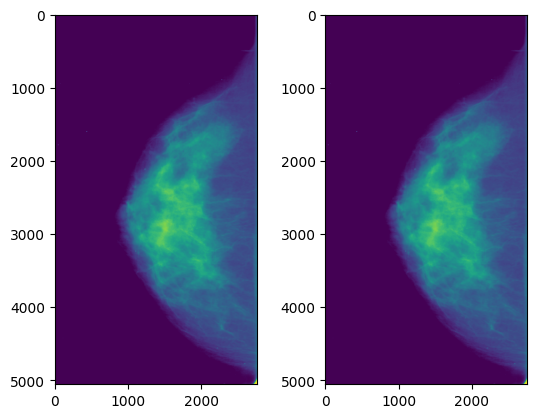

In [29]:
for idx, row in all_case.iterrows():
    cbis_image, ddsm_candidates = find_ddsm_image_diff(row)
    print(cbis_image)
    print(ddsm_candidates)
    print("-------------------")
    break
    

fig , ax = plt.subplots(1,2)
ax[0].imshow(pydicom.dcmread(cbis_image).pixel_array)
ax[1].imshow(np.array(Image.open(ddsm_candidates[0][0])))

test extrema ddsm 0 65535
test extrema cbis 0 65535
149.89207826347086


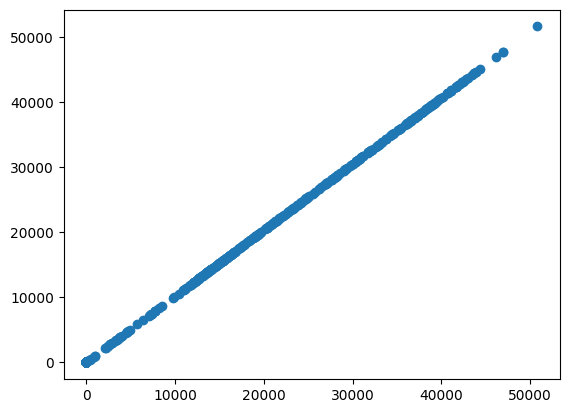

In [30]:
test_ddsm = np.array(Image.open(ddsm_candidates[0][0]))
print("test extrema ddsm", test_ddsm.min(), test_ddsm.max())

test_cbis = pydicom.dcmread(cbis_image).pixel_array
print("test extrema cbis", test_cbis.min(), test_cbis.max())



ddsm_flatten = test_ddsm.flatten()
cbis_flatten = test_cbis.flatten()

rand_indx = np.random.randint(0, len(ddsm_flatten), 1000)
plt.plot(ddsm_flatten[rand_indx], cbis_flatten[rand_indx], 'o')

print(np.abs(test_cbis - test_ddsm).mean())




---------------- 156.274
-------------------
---------------- 244.585
-------------------
---------------- 256.976


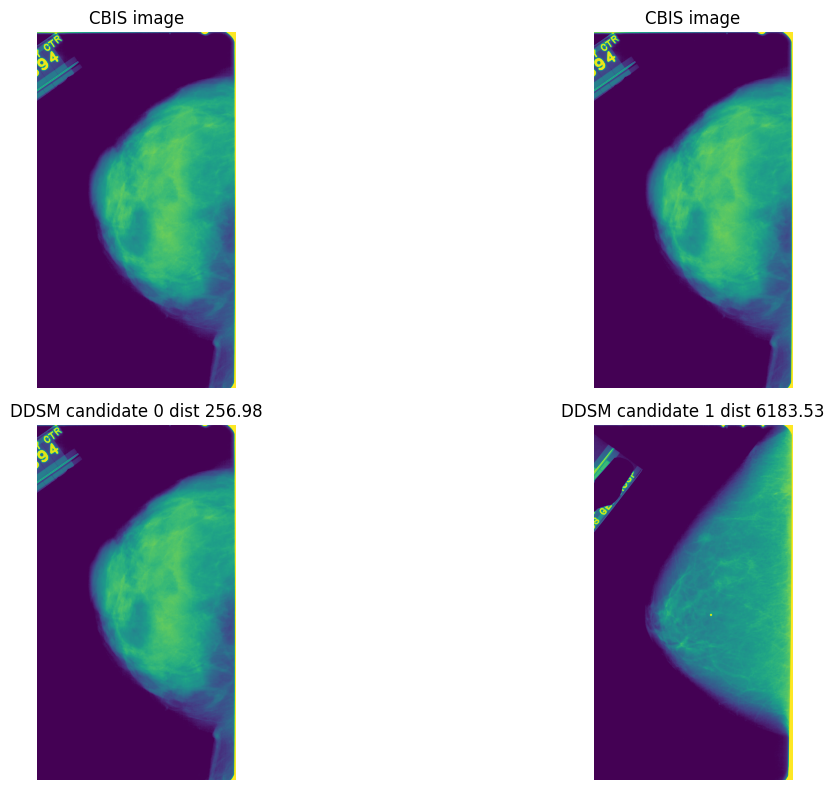

In [34]:
for idx, row in all_case.iterrows():
    cbis_image, ddsm_candidates = find_ddsm_image_diff(row)
    if len(ddsm_candidates) == 2:
        break
        print(cbis_image)
        print(ddsm_candidates)
        break 
    print("-------------------")
 
  
# Plot in the first row the CBIS image and in the second row all candidates
num_candidates = len(ddsm_candidates)
fig, ax = plt.subplots(2, num_candidates, figsize=(15, 8))  # Adjust figure size as needed

# Plot CBIS image in the first row (span across all columns)
cbis_image = pydicom.dcmread(cbis_image).pixel_array
for i in range(num_candidates):
    ax[0, i].imshow(cbis_image / cbis_image.max())
    ax[0, i].set_title('CBIS image')
    ax[0, i].axis('off')  # Hide axis if desired

# Plot all DDSM candidates in the second row
for i, candidate in enumerate(ddsm_candidates):
    ddsm_image = np.array(Image.open(candidate[0]), dtype=float)
    
    ax[1, i].imshow(ddsm_image / ddsm_image.max())
    ax[1, i].set_title(f'DDSM candidate {i} dist {candidate[1]:.2f}')
    ax[1, i].axis('off')  # Hide axis if desired

plt.tight_layout()
plt.show() 
    
#all_case['ddsm_image'] = all_case.apply(find_ddsm_image, axis=1)

In [40]:
from tqdm import tqdm
import time

matches = []

start = time.time()
num_rows = len(all_case)
for idx in tqdm(range(num_rows)):
    row = all_case.iloc[idx]
    cbis_image, ddsm_candidates = find_ddsm_image_diff(row)
    if len(ddsm_candidates) == 0:
        print("No candidates for ", cbis_image)
        break
    
    matches.append({"cbis": cbis_image, "ddsm": ddsm_candidates[0][0], "dif": ddsm_candidates[0][1]})
        
    #print(f'---------------- best candidate of {len(candidates)}: {best_candidate} - {min_dist}')
    
    
    if idx > 0 and idx % 20 == 0:
        elapsed = time.time() - start
        expected_remaining = elapsed * (num_rows-idx) / idx
        print(f'Processed {idx}/{num_rows}. Elapsed time: {elapsed:.01f} expected remaining: {int(expected_remaining)}')
        df_matches = pd.DataFrame(matches)
        df_matches.to_csv('matches.csv', index=False)
 


elapsed = time.time() - start
print(f'Elapsed time: {elapsed}')
    
df_matches = pd.DataFrame(matches)
df_matches.to_csv('matches.csv', index=False)


  1%|          | 22/3568 [00:03<10:21,  5.70it/s]

Processed 20/3568. Elapsed time: 3.8 expected remaining: 673


  1%|          | 41/3568 [00:08<12:52,  4.57it/s]

Processed 40/3568. Elapsed time: 8.3 expected remaining: 735


  2%|▏         | 61/3568 [00:12<14:52,  3.93it/s]

Processed 60/3568. Elapsed time: 12.8 expected remaining: 747


  2%|▏         | 81/3568 [00:16<09:57,  5.83it/s]

Processed 80/3568. Elapsed time: 16.7 expected remaining: 727


  3%|▎         | 102/3568 [00:26<11:13,  5.15it/s]

Processed 100/3568. Elapsed time: 25.9 expected remaining: 897


  3%|▎         | 121/3568 [00:31<23:50,  2.41it/s]

Processed 120/3568. Elapsed time: 31.8 expected remaining: 913


  4%|▍         | 141/3568 [00:41<32:45,  1.74it/s]

Processed 140/3568. Elapsed time: 41.6 expected remaining: 1019


  5%|▍         | 161/3568 [00:53<33:26,  1.70it/s]

Processed 160/3568. Elapsed time: 53.6 expected remaining: 1142


  5%|▌         | 181/3568 [01:04<33:51,  1.67it/s]

Processed 180/3568. Elapsed time: 64.7 expected remaining: 1216


  6%|▌         | 201/3568 [01:15<19:09,  2.93it/s]

Processed 200/3568. Elapsed time: 75.0 expected remaining: 1263


  6%|▌         | 221/3568 [01:24<33:01,  1.69it/s]

Processed 220/3568. Elapsed time: 84.9 expected remaining: 1291


  7%|▋         | 241/3568 [01:33<23:01,  2.41it/s]

Processed 240/3568. Elapsed time: 93.5 expected remaining: 1297


  7%|▋         | 262/3568 [01:44<15:33,  3.54it/s]

Processed 260/3568. Elapsed time: 104.0 expected remaining: 1322


  8%|▊         | 281/3568 [01:49<15:05,  3.63it/s]

Processed 280/3568. Elapsed time: 109.6 expected remaining: 1287


  8%|▊         | 301/3568 [01:59<29:49,  1.83it/s]

Processed 300/3568. Elapsed time: 119.8 expected remaining: 1304


  9%|▉         | 321/3568 [02:08<13:43,  3.94it/s]

Processed 320/3568. Elapsed time: 128.4 expected remaining: 1302


 10%|▉         | 341/3568 [02:15<12:33,  4.28it/s]

Processed 340/3568. Elapsed time: 135.9 expected remaining: 1290


 10%|█         | 361/3568 [02:23<15:41,  3.41it/s]

Processed 360/3568. Elapsed time: 144.0 expected remaining: 1282


 11%|█         | 381/3568 [02:36<34:46,  1.53it/s]

Processed 380/3568. Elapsed time: 156.6 expected remaining: 1314


 11%|█         | 401/3568 [02:45<23:19,  2.26it/s]

Processed 400/3568. Elapsed time: 165.2 expected remaining: 1308


 12%|█▏        | 421/3568 [02:53<16:08,  3.25it/s]

Processed 420/3568. Elapsed time: 173.4 expected remaining: 1299


 12%|█▏        | 442/3568 [03:00<18:01,  2.89it/s]

Processed 440/3568. Elapsed time: 180.3 expected remaining: 1282


 13%|█▎        | 461/3568 [03:07<26:07,  1.98it/s]

Processed 460/3568. Elapsed time: 187.3 expected remaining: 1265


 13%|█▎        | 481/3568 [03:16<20:03,  2.56it/s]

Processed 480/3568. Elapsed time: 197.0 expected remaining: 1267


 14%|█▍        | 501/3568 [03:27<25:00,  2.04it/s]

Processed 500/3568. Elapsed time: 207.2 expected remaining: 1271


 15%|█▍        | 521/3568 [03:37<26:54,  1.89it/s]

Processed 520/3568. Elapsed time: 217.3 expected remaining: 1273


 15%|█▌        | 541/3568 [03:47<21:17,  2.37it/s]

Processed 540/3568. Elapsed time: 227.8 expected remaining: 1277


 16%|█▌        | 561/3568 [03:57<25:10,  1.99it/s]

Processed 560/3568. Elapsed time: 237.3 expected remaining: 1274


 16%|█▋        | 581/3568 [04:06<23:49,  2.09it/s]

Processed 580/3568. Elapsed time: 246.5 expected remaining: 1269


 17%|█▋        | 601/3568 [04:16<14:27,  3.42it/s]

Processed 600/3568. Elapsed time: 256.3 expected remaining: 1268


 17%|█▋        | 622/3568 [04:26<12:01,  4.08it/s]

Processed 620/3568. Elapsed time: 265.9 expected remaining: 1264


 18%|█▊        | 641/3568 [04:32<22:10,  2.20it/s]

Processed 640/3568. Elapsed time: 272.8 expected remaining: 1248


 19%|█▊        | 661/3568 [04:41<19:10,  2.53it/s]

Processed 660/3568. Elapsed time: 281.9 expected remaining: 1242


 19%|█▉        | 681/3568 [04:52<21:21,  2.25it/s]

Processed 680/3568. Elapsed time: 292.7 expected remaining: 1243


 20%|█▉        | 701/3568 [05:02<22:22,  2.14it/s]

Processed 700/3568. Elapsed time: 302.2 expected remaining: 1238


 20%|██        | 722/3568 [05:13<17:19,  2.74it/s]

Processed 720/3568. Elapsed time: 313.4 expected remaining: 1239


 21%|██        | 741/3568 [05:21<15:55,  2.96it/s]

Processed 740/3568. Elapsed time: 321.7 expected remaining: 1229


 21%|██▏       | 761/3568 [05:33<24:11,  1.93it/s]

Processed 760/3568. Elapsed time: 333.4 expected remaining: 1231


 22%|██▏       | 781/3568 [05:43<22:08,  2.10it/s]

Processed 780/3568. Elapsed time: 343.1 expected remaining: 1226


 22%|██▏       | 801/3568 [05:51<19:01,  2.42it/s]

Processed 800/3568. Elapsed time: 351.9 expected remaining: 1217


 23%|██▎       | 821/3568 [06:01<32:27,  1.41it/s]

Processed 820/3568. Elapsed time: 361.7 expected remaining: 1212


 24%|██▎       | 841/3568 [06:14<27:24,  1.66it/s]

Processed 840/3568. Elapsed time: 374.6 expected remaining: 1216


 24%|██▍       | 861/3568 [06:23<13:09,  3.43it/s]

Processed 860/3568. Elapsed time: 383.1 expected remaining: 1206


 25%|██▍       | 881/3568 [06:33<27:14,  1.64it/s]

Processed 880/3568. Elapsed time: 393.0 expected remaining: 1200


 25%|██▌       | 901/3568 [06:42<22:51,  1.94it/s]

Processed 900/3568. Elapsed time: 403.0 expected remaining: 1194


 26%|██▌       | 921/3568 [06:50<14:16,  3.09it/s]

Processed 920/3568. Elapsed time: 410.4 expected remaining: 1181


 26%|██▋       | 941/3568 [06:59<20:31,  2.13it/s]

Processed 940/3568. Elapsed time: 420.0 expected remaining: 1174


 27%|██▋       | 961/3568 [07:09<19:51,  2.19it/s]

Processed 960/3568. Elapsed time: 429.7 expected remaining: 1167


 27%|██▋       | 981/3568 [07:18<22:22,  1.93it/s]

Processed 980/3568. Elapsed time: 438.6 expected remaining: 1158


 28%|██▊       | 1001/3568 [07:27<20:53,  2.05it/s]

Processed 1000/3568. Elapsed time: 447.0 expected remaining: 1148


 29%|██▊       | 1021/3568 [07:35<20:46,  2.04it/s]

Processed 1020/3568. Elapsed time: 455.4 expected remaining: 1137


 29%|██▉       | 1041/3568 [07:43<16:29,  2.55it/s]

Processed 1040/3568. Elapsed time: 463.5 expected remaining: 1126


 30%|██▉       | 1061/3568 [07:53<23:20,  1.79it/s]

Processed 1060/3568. Elapsed time: 474.0 expected remaining: 1121


 30%|███       | 1081/3568 [08:04<18:58,  2.18it/s]

Processed 1080/3568. Elapsed time: 484.8 expected remaining: 1116


 31%|███       | 1101/3568 [08:12<11:42,  3.51it/s]

Processed 1100/3568. Elapsed time: 492.7 expected remaining: 1105


 31%|███▏      | 1121/3568 [08:20<14:49,  2.75it/s]

Processed 1120/3568. Elapsed time: 500.5 expected remaining: 1093


 32%|███▏      | 1142/3568 [08:23<06:03,  6.67it/s]

Processed 1140/3568. Elapsed time: 503.8 expected remaining: 1072


 33%|███▎      | 1162/3568 [08:31<15:46,  2.54it/s]

Processed 1160/3568. Elapsed time: 511.6 expected remaining: 1061


 33%|███▎      | 1181/3568 [08:39<17:51,  2.23it/s]

Processed 1180/3568. Elapsed time: 519.6 expected remaining: 1051


 34%|███▎      | 1201/3568 [08:49<22:14,  1.77it/s]

Processed 1200/3568. Elapsed time: 529.7 expected remaining: 1045


 34%|███▍      | 1222/3568 [08:55<06:15,  6.24it/s]

Processed 1220/3568. Elapsed time: 535.0 expected remaining: 1029


 35%|███▍      | 1241/3568 [09:03<22:58,  1.69it/s]

Processed 1240/3568. Elapsed time: 543.5 expected remaining: 1020


 35%|███▌      | 1261/3568 [09:14<18:27,  2.08it/s]

Processed 1260/3568. Elapsed time: 554.6 expected remaining: 1015


 36%|███▌      | 1281/3568 [09:22<16:53,  2.26it/s]

Processed 1280/3568. Elapsed time: 562.3 expected remaining: 1005


 36%|███▋      | 1302/3568 [09:30<07:56,  4.76it/s]

Processed 1300/3568. Elapsed time: 570.6 expected remaining: 995


 37%|███▋      | 1321/3568 [09:41<20:01,  1.87it/s]

Processed 1320/3568. Elapsed time: 581.7 expected remaining: 990


 38%|███▊      | 1341/3568 [09:52<24:36,  1.51it/s]

Processed 1340/3568. Elapsed time: 592.9 expected remaining: 985


 38%|███▊      | 1361/3568 [10:01<10:58,  3.35it/s]

Processed 1360/3568. Elapsed time: 601.4 expected remaining: 976


 39%|███▊      | 1381/3568 [10:11<17:33,  2.08it/s]

Processed 1380/3568. Elapsed time: 611.9 expected remaining: 970


 39%|███▉      | 1402/3568 [10:18<08:50,  4.08it/s]

Processed 1400/3568. Elapsed time: 618.7 expected remaining: 958


 40%|███▉      | 1421/3568 [10:27<18:36,  1.92it/s]

Processed 1420/3568. Elapsed time: 627.7 expected remaining: 949


 40%|████      | 1441/3568 [10:35<11:31,  3.07it/s]

Processed 1440/3568. Elapsed time: 635.1 expected remaining: 938


 41%|████      | 1461/3568 [10:44<21:40,  1.62it/s]

Processed 1460/3568. Elapsed time: 644.7 expected remaining: 930


 42%|████▏     | 1481/3568 [10:53<15:11,  2.29it/s]

Processed 1480/3568. Elapsed time: 653.2 expected remaining: 921


 42%|████▏     | 1501/3568 [11:05<16:38,  2.07it/s]

Processed 1500/3568. Elapsed time: 665.7 expected remaining: 917


 43%|████▎     | 1521/3568 [11:15<18:22,  1.86it/s]

Processed 1520/3568. Elapsed time: 675.7 expected remaining: 910


 43%|████▎     | 1541/3568 [11:25<20:51,  1.62it/s]

Processed 1540/3568. Elapsed time: 685.7 expected remaining: 903


 44%|████▍     | 1561/3568 [11:37<16:13,  2.06it/s]

Processed 1560/3568. Elapsed time: 697.2 expected remaining: 897


 44%|████▍     | 1581/3568 [11:47<17:24,  1.90it/s]

Processed 1580/3568. Elapsed time: 707.4 expected remaining: 890


 45%|████▍     | 1601/3568 [11:58<22:00,  1.49it/s]

Processed 1600/3568. Elapsed time: 718.6 expected remaining: 883


 45%|████▌     | 1621/3568 [12:07<15:59,  2.03it/s]

Processed 1620/3568. Elapsed time: 727.4 expected remaining: 874


 46%|████▌     | 1641/3568 [12:15<18:45,  1.71it/s]

Processed 1640/3568. Elapsed time: 735.1 expected remaining: 864


 47%|████▋     | 1661/3568 [12:27<19:04,  1.67it/s]

Processed 1660/3568. Elapsed time: 747.1 expected remaining: 858


 47%|████▋     | 1681/3568 [12:38<25:31,  1.23it/s]

Processed 1680/3568. Elapsed time: 758.1 expected remaining: 851


 48%|████▊     | 1701/3568 [12:46<13:29,  2.31it/s]

Processed 1700/3568. Elapsed time: 766.4 expected remaining: 842


 48%|████▊     | 1721/3568 [12:57<18:04,  1.70it/s]

Processed 1720/3568. Elapsed time: 777.9 expected remaining: 835


 49%|████▉     | 1741/3568 [13:08<15:26,  1.97it/s]

Processed 1740/3568. Elapsed time: 788.8 expected remaining: 828


 49%|████▉     | 1761/3568 [13:17<15:10,  1.98it/s]

Processed 1760/3568. Elapsed time: 797.8 expected remaining: 819


 50%|████▉     | 1781/3568 [13:27<12:56,  2.30it/s]

Processed 1780/3568. Elapsed time: 807.1 expected remaining: 810


 50%|█████     | 1801/3568 [13:37<12:58,  2.27it/s]

Processed 1800/3568. Elapsed time: 817.4 expected remaining: 802


 51%|█████     | 1821/3568 [13:48<16:40,  1.75it/s]

Processed 1820/3568. Elapsed time: 829.0 expected remaining: 796


 52%|█████▏    | 1841/3568 [13:58<10:54,  2.64it/s]

Processed 1840/3568. Elapsed time: 838.3 expected remaining: 787


 52%|█████▏    | 1861/3568 [14:07<13:37,  2.09it/s]

Processed 1860/3568. Elapsed time: 847.7 expected remaining: 778


 53%|█████▎    | 1881/3568 [14:19<16:54,  1.66it/s]

Processed 1880/3568. Elapsed time: 859.1 expected remaining: 771


 53%|█████▎    | 1901/3568 [14:30<17:47,  1.56it/s]

Processed 1900/3568. Elapsed time: 870.9 expected remaining: 764


 54%|█████▍    | 1921/3568 [14:41<15:00,  1.83it/s]

Processed 1920/3568. Elapsed time: 881.0 expected remaining: 756


 54%|█████▍    | 1941/3568 [14:52<18:23,  1.47it/s]

Processed 1940/3568. Elapsed time: 892.9 expected remaining: 749


 55%|█████▍    | 1962/3568 [15:02<10:28,  2.55it/s]

Processed 1960/3568. Elapsed time: 902.7 expected remaining: 740


 56%|█████▌    | 1981/3568 [15:14<14:03,  1.88it/s]

Processed 1980/3568. Elapsed time: 914.4 expected remaining: 733


 56%|█████▌    | 2001/3568 [15:26<17:59,  1.45it/s]

Processed 2000/3568. Elapsed time: 926.1 expected remaining: 726


 57%|█████▋    | 2021/3568 [15:35<11:01,  2.34it/s]

Processed 2020/3568. Elapsed time: 935.9 expected remaining: 717


 57%|█████▋    | 2041/3568 [15:47<13:37,  1.87it/s]

Processed 2040/3568. Elapsed time: 947.5 expected remaining: 709


 58%|█████▊    | 2061/3568 [15:59<13:04,  1.92it/s]

Processed 2060/3568. Elapsed time: 959.0 expected remaining: 702


 58%|█████▊    | 2081/3568 [16:10<16:57,  1.46it/s]

Processed 2080/3568. Elapsed time: 970.6 expected remaining: 694


 59%|█████▉    | 2101/3568 [16:20<09:24,  2.60it/s]

Processed 2100/3568. Elapsed time: 980.4 expected remaining: 685


 59%|█████▉    | 2121/3568 [16:29<11:33,  2.09it/s]

Processed 2120/3568. Elapsed time: 989.7 expected remaining: 675


 60%|██████    | 2141/3568 [16:40<11:29,  2.07it/s]

Processed 2140/3568. Elapsed time: 1000.5 expected remaining: 667


 61%|██████    | 2161/3568 [16:51<13:35,  1.73it/s]

Processed 2160/3568. Elapsed time: 1011.6 expected remaining: 659


 61%|██████    | 2181/3568 [17:02<13:02,  1.77it/s]

Processed 2180/3568. Elapsed time: 1022.1 expected remaining: 650


 62%|██████▏   | 2201/3568 [17:11<10:27,  2.18it/s]

Processed 2200/3568. Elapsed time: 1031.6 expected remaining: 641


 62%|██████▏   | 2221/3568 [17:23<15:17,  1.47it/s]

Processed 2220/3568. Elapsed time: 1043.6 expected remaining: 633


 63%|██████▎   | 2241/3568 [17:35<11:24,  1.94it/s]

Processed 2240/3568. Elapsed time: 1055.3 expected remaining: 625


 63%|██████▎   | 2261/3568 [17:45<09:21,  2.33it/s]

Processed 2260/3568. Elapsed time: 1065.7 expected remaining: 616


 64%|██████▍   | 2281/3568 [17:56<10:29,  2.04it/s]

Processed 2280/3568. Elapsed time: 1076.2 expected remaining: 607


 64%|██████▍   | 2301/3568 [18:07<09:46,  2.16it/s]

Processed 2300/3568. Elapsed time: 1087.0 expected remaining: 599


 65%|██████▌   | 2321/3568 [18:16<08:48,  2.36it/s]

Processed 2320/3568. Elapsed time: 1096.3 expected remaining: 589


 66%|██████▌   | 2341/3568 [18:26<10:28,  1.95it/s]

Processed 2340/3568. Elapsed time: 1106.6 expected remaining: 580


 66%|██████▌   | 2361/3568 [18:39<17:46,  1.13it/s]

Processed 2360/3568. Elapsed time: 1119.6 expected remaining: 573


 67%|██████▋   | 2381/3568 [18:51<15:38,  1.27it/s]

Processed 2380/3568. Elapsed time: 1131.2 expected remaining: 564


 67%|██████▋   | 2401/3568 [19:02<10:53,  1.79it/s]

Processed 2400/3568. Elapsed time: 1142.8 expected remaining: 556


 68%|██████▊   | 2421/3568 [19:14<10:03,  1.90it/s]

Processed 2420/3568. Elapsed time: 1154.1 expected remaining: 547


 68%|██████▊   | 2441/3568 [19:25<10:50,  1.73it/s]

Processed 2440/3568. Elapsed time: 1165.9 expected remaining: 538


 69%|██████▉   | 2461/3568 [19:35<08:41,  2.12it/s]

Processed 2460/3568. Elapsed time: 1175.5 expected remaining: 529


 70%|██████▉   | 2481/3568 [19:45<10:37,  1.71it/s]

Processed 2480/3568. Elapsed time: 1185.1 expected remaining: 519


 70%|███████   | 2501/3568 [19:56<10:38,  1.67it/s]

Processed 2500/3568. Elapsed time: 1196.0 expected remaining: 510


 71%|███████   | 2521/3568 [20:05<08:52,  1.97it/s]

Processed 2520/3568. Elapsed time: 1205.6 expected remaining: 501


 71%|███████   | 2541/3568 [20:16<09:28,  1.81it/s]

Processed 2540/3568. Elapsed time: 1216.5 expected remaining: 492


 72%|███████▏  | 2561/3568 [20:28<11:15,  1.49it/s]

Processed 2560/3568. Elapsed time: 1229.0 expected remaining: 483


 72%|███████▏  | 2581/3568 [20:39<07:51,  2.10it/s]

Processed 2580/3568. Elapsed time: 1239.4 expected remaining: 474


 73%|███████▎  | 2601/3568 [20:49<09:37,  1.67it/s]

Processed 2600/3568. Elapsed time: 1249.4 expected remaining: 465


 73%|███████▎  | 2621/3568 [21:01<08:56,  1.77it/s]

Processed 2620/3568. Elapsed time: 1261.1 expected remaining: 456


 74%|███████▍  | 2641/3568 [21:14<07:14,  2.13it/s]

Processed 2640/3568. Elapsed time: 1274.2 expected remaining: 447


 75%|███████▍  | 2661/3568 [21:25<08:31,  1.77it/s]

Processed 2660/3568. Elapsed time: 1285.4 expected remaining: 438


 75%|███████▌  | 2681/3568 [21:35<08:27,  1.75it/s]

Processed 2680/3568. Elapsed time: 1295.2 expected remaining: 429


 76%|███████▌  | 2701/3568 [21:47<07:11,  2.01it/s]

Processed 2700/3568. Elapsed time: 1307.0 expected remaining: 420


 76%|███████▋  | 2721/3568 [21:55<06:10,  2.28it/s]

Processed 2720/3568. Elapsed time: 1315.0 expected remaining: 409


 77%|███████▋  | 2741/3568 [22:07<09:22,  1.47it/s]

Processed 2740/3568. Elapsed time: 1327.7 expected remaining: 401


 77%|███████▋  | 2761/3568 [22:18<08:47,  1.53it/s]

Processed 2760/3568. Elapsed time: 1338.9 expected remaining: 391


 78%|███████▊  | 2781/3568 [22:30<06:28,  2.02it/s]

Processed 2780/3568. Elapsed time: 1350.9 expected remaining: 382


 79%|███████▊  | 2801/3568 [22:41<05:51,  2.18it/s]

Processed 2800/3568. Elapsed time: 1361.5 expected remaining: 373


 79%|███████▉  | 2821/3568 [22:52<06:43,  1.85it/s]

Processed 2820/3568. Elapsed time: 1372.7 expected remaining: 364


 80%|███████▉  | 2841/3568 [23:04<05:49,  2.08it/s]

Processed 2840/3568. Elapsed time: 1384.7 expected remaining: 354


 80%|████████  | 2861/3568 [23:15<06:31,  1.81it/s]

Processed 2860/3568. Elapsed time: 1395.9 expected remaining: 345


 81%|████████  | 2881/3568 [23:25<06:18,  1.82it/s]

Processed 2880/3568. Elapsed time: 1405.2 expected remaining: 335


 81%|████████▏ | 2901/3568 [23:34<05:25,  2.05it/s]

Processed 2900/3568. Elapsed time: 1414.2 expected remaining: 325


 82%|████████▏ | 2921/3568 [23:47<07:04,  1.52it/s]

Processed 2920/3568. Elapsed time: 1427.2 expected remaining: 316


 82%|████████▏ | 2941/3568 [23:55<04:29,  2.33it/s]

Processed 2940/3568. Elapsed time: 1435.6 expected remaining: 306


 83%|████████▎ | 2961/3568 [24:04<03:53,  2.60it/s]

Processed 2960/3568. Elapsed time: 1444.2 expected remaining: 296


 84%|████████▎ | 2981/3568 [24:14<04:41,  2.09it/s]

Processed 2980/3568. Elapsed time: 1454.8 expected remaining: 287


 84%|████████▍ | 3001/3568 [24:24<04:09,  2.27it/s]

Processed 3000/3568. Elapsed time: 1464.4 expected remaining: 277


 85%|████████▍ | 3021/3568 [24:34<03:47,  2.40it/s]

Processed 3020/3568. Elapsed time: 1474.8 expected remaining: 267


 85%|████████▌ | 3041/3568 [24:44<05:21,  1.64it/s]

Processed 3040/3568. Elapsed time: 1484.4 expected remaining: 257


 86%|████████▌ | 3061/3568 [24:52<03:56,  2.15it/s]

Processed 3060/3568. Elapsed time: 1492.4 expected remaining: 247


 86%|████████▋ | 3081/3568 [25:01<03:18,  2.46it/s]

Processed 3080/3568. Elapsed time: 1501.8 expected remaining: 237


 87%|████████▋ | 3101/3568 [25:10<04:18,  1.81it/s]

Processed 3100/3568. Elapsed time: 1510.7 expected remaining: 228


 87%|████████▋ | 3121/3568 [25:21<04:23,  1.70it/s]

Processed 3120/3568. Elapsed time: 1521.3 expected remaining: 218


 88%|████████▊ | 3141/3568 [25:29<03:23,  2.10it/s]

Processed 3140/3568. Elapsed time: 1529.2 expected remaining: 208


 89%|████████▊ | 3161/3568 [25:37<02:52,  2.36it/s]

Processed 3160/3568. Elapsed time: 1537.9 expected remaining: 198


 89%|████████▉ | 3181/3568 [25:50<03:59,  1.61it/s]

Processed 3180/3568. Elapsed time: 1550.0 expected remaining: 189


 90%|████████▉ | 3201/3568 [26:00<02:25,  2.52it/s]

Processed 3200/3568. Elapsed time: 1560.2 expected remaining: 179


 90%|█████████ | 3221/3568 [26:11<03:40,  1.57it/s]

Processed 3220/3568. Elapsed time: 1571.3 expected remaining: 169


 91%|█████████ | 3241/3568 [26:21<03:40,  1.49it/s]

Processed 3240/3568. Elapsed time: 1581.9 expected remaining: 160


 91%|█████████▏| 3262/3568 [26:33<01:39,  3.09it/s]

Processed 3260/3568. Elapsed time: 1592.9 expected remaining: 150


 92%|█████████▏| 3281/3568 [26:43<03:41,  1.30it/s]

Processed 3280/3568. Elapsed time: 1603.4 expected remaining: 140


 93%|█████████▎| 3301/3568 [26:54<01:57,  2.27it/s]

Processed 3300/3568. Elapsed time: 1614.3 expected remaining: 131


 93%|█████████▎| 3321/3568 [27:06<02:11,  1.87it/s]

Processed 3320/3568. Elapsed time: 1626.8 expected remaining: 121


 94%|█████████▎| 3341/3568 [27:18<02:10,  1.75it/s]

Processed 3340/3568. Elapsed time: 1638.6 expected remaining: 111


 94%|█████████▍| 3361/3568 [27:30<02:04,  1.66it/s]

Processed 3360/3568. Elapsed time: 1650.5 expected remaining: 102


 95%|█████████▍| 3381/3568 [27:40<01:29,  2.08it/s]

Processed 3380/3568. Elapsed time: 1660.7 expected remaining: 92


 95%|█████████▌| 3401/3568 [27:50<01:33,  1.78it/s]

Processed 3400/3568. Elapsed time: 1670.1 expected remaining: 82


 96%|█████████▌| 3421/3568 [28:01<01:50,  1.32it/s]

Processed 3420/3568. Elapsed time: 1681.3 expected remaining: 72


 96%|█████████▋| 3441/3568 [28:13<01:20,  1.58it/s]

Processed 3440/3568. Elapsed time: 1693.4 expected remaining: 63


 97%|█████████▋| 3461/3568 [28:24<01:00,  1.78it/s]

Processed 3460/3568. Elapsed time: 1704.8 expected remaining: 53


 98%|█████████▊| 3481/3568 [28:37<01:08,  1.27it/s]

Processed 3480/3568. Elapsed time: 1717.7 expected remaining: 43


 98%|█████████▊| 3501/3568 [28:49<00:45,  1.46it/s]

Processed 3500/3568. Elapsed time: 1729.2 expected remaining: 33


 99%|█████████▊| 3521/3568 [28:59<00:25,  1.83it/s]

Processed 3520/3568. Elapsed time: 1739.7 expected remaining: 23


 99%|█████████▉| 3541/3568 [29:10<00:14,  1.88it/s]

Processed 3540/3568. Elapsed time: 1750.4 expected remaining: 13


100%|█████████▉| 3561/3568 [29:22<00:03,  2.00it/s]

Processed 3560/3568. Elapsed time: 1762.4 expected remaining: 3


100%|██████████| 3568/3568 [29:25<00:00,  2.02it/s]

Elapsed time: 1765.2559878826141


In [42]:
df_matches.sort_values('dif', ascending=False).head(10)

,cbis,ddsm,dif
522,/media/HD/mamo/CBIS-DDSM/Calc-Training_P_00652...,/media/HD/mamo/DDSM_png_noclipping/cases/cance...,59663.187
3342,/media/HD/mamo/CBIS-DDSM/Mass-Test_P_00652_LEF...,/media/HD/mamo/DDSM_png_noclipping/cases/cance...,59189.489
523,/media/HD/mamo/CBIS-DDSM/Calc-Training_P_00652...,/media/HD/mamo/DDSM_png_noclipping/cases/cance...,52525.798
2393,/media/HD/mamo/CBIS-DDSM/Mass-Training_P_01216...,/media/HD/mamo/DDSM_png_noclipping/cases/benig...,4319.867
2454,/media/HD/mamo/CBIS-DDSM/Mass-Training_P_01285...,/media/HD/mamo/DDSM_png_noclipping/cases/benig...,3531.059
1467,/media/HD/mamo/CBIS-DDSM/Calc-Training_P_02195...,/media/HD/mamo/DDSM_png_noclipping/cases/cance...,3090.787
498,/media/HD/mamo/CBIS-DDSM/Calc-Training_P_00624...,/media/HD/mamo/DDSM_png_noclipping/cases/benig...,2901.417
1429,/media/HD/mamo/CBIS-DDSM/Calc-Training_P_01856...,/media/HD/mamo/DDSM_png_noclipping/cases/cance...,2849.831
2753,/media/HD/mamo/CBIS-DDSM/Mass-Training_P_01735...,/media/HD/mamo/DDSM_png_noclipping/cases/cance...,2700.716
631,/media/HD/mamo/CBIS-DDSM/Calc-Training_P_00787...,/media/HD/mamo/DDSM_png_noclipping/cases/cance...,2623.018


In [ ]:
def plot_matches(row):
    cbis_image_filename = cbis_ddsm_path / row['cbis']
    cbis_image = pydicom.dcmread(cbis_image_filename).pixel_array
    ddsm_image = np.array(Image.open(row['ddsm']), dtype=float)
    dif = row['dif']
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))  # Adjust figure size as needed

    ax[0].imshow(cbis_image)
    ax[0].set_title('CBIS image')
    ax[0].axis('off')  # Hide axis if desired

    ax[1].imshow(ddsm_image)
    ax[1].set_title('DDSM image')
    ax[1].axis('off')  # Hide axis if desired
    
    #set title with distance
    fig.suptitle(f'Dif: {dif:.4f}')

    plt.tight_layout()
    plt.show()
    
# select row using interact 
from ipywidgets import interact

@interact(idx=(0, 20))
def show_matches(idx=0):
    plot_matches(df_matches.sort_values('dif', ascending=False).iloc[idx])

interactive(children=(IntSlider(value=0, description='idx', max=20), Output()), _dom_classes=('widget-interact…

In [47]:
df_matches = pd.read_csv('matches.csv')
sorted_matches = df_matches.sort_values('dif', ascending=False)

corruped_images = []
for k in range(4):
    row = sorted_matches.iloc[k]
    ddsm_image = np.array(Image.open(row['ddsm']), dtype=float)

    print(row['ddsm'],ddsm_image.min(), ddsm_image.max())
    corruped_images.append(row)
    

corruped_images = pd.DataFrame(corruped_images)
#print(corruped_images)  
# claramente las malas estan todas blancas y hay que cambiarlas por las buenas de momento las 3 primeras

all_case['case_id'] = all_case['image file path'].str.split('/').str[0]

for idx, row in corruped_images.iterrows():
    cbis_image = row['cbis'].replace('/media/HD/mamo/CBIS-DDSM/','')
    ddsm_image = row['ddsm']
    print(cbis_image)
    id = all_case.loc[all_case['case_id'] == cbis_image.split('/')[0]].id.values[0]
    cbis_image_same_id = all_case.loc[all_case['id'] == id]
    
    print("The number of images with same id", len(cbis_image_same_id))
    
    for cbis_image in cbis_image_same_id['image file path'].values:
        for k, match in df_matches.iterrows():
            if cbis_image.split('/')[0] in match['cbis']:
                print(match['ddsm'], match['dif'])
                break
            
        
    
    
    
    print("__________________")
    #print(ddsm_image)
    




/media/HD/mamo/DDSM_png_noclipping/cases/cancers/cancer_15/case3043/B_3043_1.LEFT_CC.png 65535.0 65535.0
/media/HD/mamo/DDSM_png_noclipping/cases/cancers/cancer_15/case3043/B_3043_1.LEFT_CC.png 65535.0 65535.0
/media/HD/mamo/DDSM_png_noclipping/cases/cancers/cancer_15/case3043/B_3043_1.LEFT_MLO.png 65535.0 65535.0
/media/HD/mamo/DDSM_png_noclipping/cases/benigns/benign_06/case0321/C_0321_1.RIGHT_CC.png 0.0 65535.0
Calc-Training_P_00652_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.98254843011020947026766276371179287106/1.3.6.1.4.1.9590.100.1.2.257617740013427122633260799063615303930/00000001.dcm
The number of images with same id 2
/media/HD/mamo/DDSM_png_noclipping/cases/cancers/cancer_15/case3043/B_3043_1.LEFT_CC.png 59663.187
/media/HD/mamo/DDSM_png_noclipping/cases/cancers/cancer_15/case3043/B_3043_1.LEFT_CC.png 59189.489
__________________
Mass-Test_P_00652_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.163146166812080534715560331731679187823/1.3.6.1.4.1.9590.100.1.2.351095773812262405525829356842200610924/0

In [75]:
problematic_ddsm_images = []

for ddsm_image in tqdm(ddsm_images['image_path'].values):
    
    
    image = np.array(Image.open(ddsm_image))
    if image.max() - image.min() < 1000:
        problematic_ddsm_images.append(ddsm_image)
        print(f"{ddsm_image} is problematic {image.max() - image.min()}")
        with open('problematic_ddsm_images.txt', 'a') as f:
            f.write(f'{ddsm_image} {image.max() - image.min()} \n')
 
    
        

print("Number of problematic ddsm images", len(problematic_ddsm_images))


  1%|▏         | 154/10420 [00:31<34:35,  4.95it/s]


KeyboardInterrupt: 

In [ ]:
for ddsm_image in ddsm_images:
    print(ddsm_image)

False

In [13]:
for ddsm_image_name in tqdm(ddsm_images.image_path.values):
    if "cancer_15" in ddsm_image_name:
        ddsm_image = Image.open(ddsm_image_name)
        ddsm_image = np.array(ddsm_image, dtype=float)
        if ddsm_image.max() - ddsm_image.min() < 100:
            print(ddsm_image_name, ddsm_image.min(), ddsm_image.max())
        

NameError: name 'tqdm' is not defined

# Classify DDSM intro train/test

In [8]:
import pandas as pd

df_matches = pd.read_csv('matches_ddsm_CBIS_DDSM.csv')

def split_train_test(row):
    if row['cbis_image'] in all_case_train['image file path'].values:
        return 'train'
    elif row['cbis_image'] in all_case_test['image file path'].values:
        return 'test'
    else:
        return 'unknown'
    
df_matches['split'] = df_matches.apply(split_train_test, axis=1)
    


In [9]:
df_matches['split'].value_counts()

split
train    2864
test      704
Name: count, dtype: int64

In [13]:
print("number of images ", len(df_matches.cbis_image.unique()))
print("number of images ", len(df_matches.ddsm_image.unique()))
print("number of lessions ", len(all_case))

number of images  3103
number of images  3032
number of lessions  3568


El numero de imágenes de DDSM es menor porque en CBIS han repetido imagenes que tienen ambos tipos de lesiones con nombres diferentes.

In [15]:
#find ddsm_images that have more than one cbis_image
# group by ddsm_image and count the number of unique cbis_image

df_matches.groupby('ddsm_image').cbis_image.nunique().sort_values(ascending=False).head(10)

ddsm_image
/home/alalbiol/Data/mamo/DDSM_png/cancers/cancer_06/case1212/A_1212_1.LEFT_MLO.png                                       2
/home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_02/case3429/B_3429_1.RIGHT_MLO.png    2
/home/alalbiol/Data/mamo/DDSM_png/cancers/cancer_09/case0008/C_0008_1.RIGHT_CC.png                                       2
/home/alalbiol/Data/mamo/DDSM_png/cancers/cancer_02/case0068/C_0068_1.RIGHT_CC.png                                       2
/home/alalbiol/Data/mamo/DDSM_png/cancers/cancer_02/case0068/C_0068_1.RIGHT_MLO.png                                      2
/home/alalbiol/Data/mamo/DDSM_png/benigns/benign_04/case0302/C_0302_1.RIGHT_MLO.png                                      2
/home/alalbiol/Data/mamo/DDSM_png/benigns/benign_04/case0304/C_0304_1.RIGHT_CC.png                                       2
/home/alalbiol/Data/mamo/DDSM_png/benigns/benign_04/case0304/C_0304_1.RIGHT_MLO.png                                      2
/home

In [16]:
# create a dictionary of sets with the cbis_images that are matched to each ddsm_image

ddsm_cbis = df_matches.groupby('ddsm_image').cbis_image.unique().to_dict()

In [23]:
def check_same_patient(cbis_images):
    clean_names = [x.split('/')[0] for x in cbis_images] # results as 'Calc-Training_P_00924_RIGHT_CC'
    clean_names = ["_".join(x.split('_')[1:]) for x in clean_names] # removes the first part of the name as 'P_00924_RIGHT_CC'
    return len(set(clean_names)) == 1
    
    
k = 0
for ddsm_image, cbis_images in ddsm_cbis.items():
    if len(cbis_images) > 1:
        k += 1
        print(f"{k} {ddsm_image} - {[x.split('/')[0] for x in cbis_images]}")
        if not check_same_patient(cbis_images):
            print("Different patients:", cbis_images)
            break
        


1 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_01/case3167/B_3167_1.RIGHT_CC.png - ['Calc-Training_P_00924_RIGHT_CC', 'Mass-Test_P_00924_RIGHT_CC']
2 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_01/case3171/B_3171_1.LEFT_CC.png - ['Mass-Training_P_00041_LEFT_CC', 'Calc-Test_P_00041_LEFT_CC']
3 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_01/case3171/B_3171_1.LEFT_MLO.png - ['Mass-Training_P_00041_LEFT_MLO', 'Calc-Test_P_00041_LEFT_MLO']
4 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_01/case3176/B_3176_1.RIGHT_MLO.png - ['Calc-Training_P_01274_RIGHT_MLO', 'Mass-Training_P_01274_RIGHT_MLO']
5 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_01/case3188/B_3188_1.RIGHT_CC.png - ['Calc-Training_P_00106_RIGHT_CC', 'Mass-Training_P_00106_RIGHT_CC']
6 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/b